In [1]:
%matplotlib notebook

from rlsm.datasets import load_spanish_highschool
from rlsm import ReciprocityLSM

In [2]:
Y, features = load_spanish_highschool()

In [3]:
model = ReciprocityLSM(n_features=2, reciprocity_type='distance', random_state=42)
model.sample(Y, n_warmup=2500, n_samples=2500)

sample: 100%|██████████████████████████████████████████████████████████████████| 5000/5000 [04:58<00:00, 16.75it/s, 63 steps of size 5.12e-02. acc. prob=0.83]


In [4]:
model.print_summary()

AUC: 0.962, WAIC: 11986.138

                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     a_sigma      4.06      0.52      4.03      3.21      4.92    229.04      1.01
    ab_sigma     -0.15      0.15     -0.14     -0.39      0.10    257.46      1.00
     b_sigma      0.69      0.10      0.69      0.53      0.86    475.65      1.01
   dist_coef     -0.33      0.08     -0.33     -0.47     -0.20    808.39      1.00
  recip_coef      2.06      0.17      2.05      1.78      2.32    818.24      1.00
     u_sigma      3.50      0.14      3.49      3.28      3.72    330.06      1.00

Number of divergences: 296


<IPython.core.display.Javascript object>


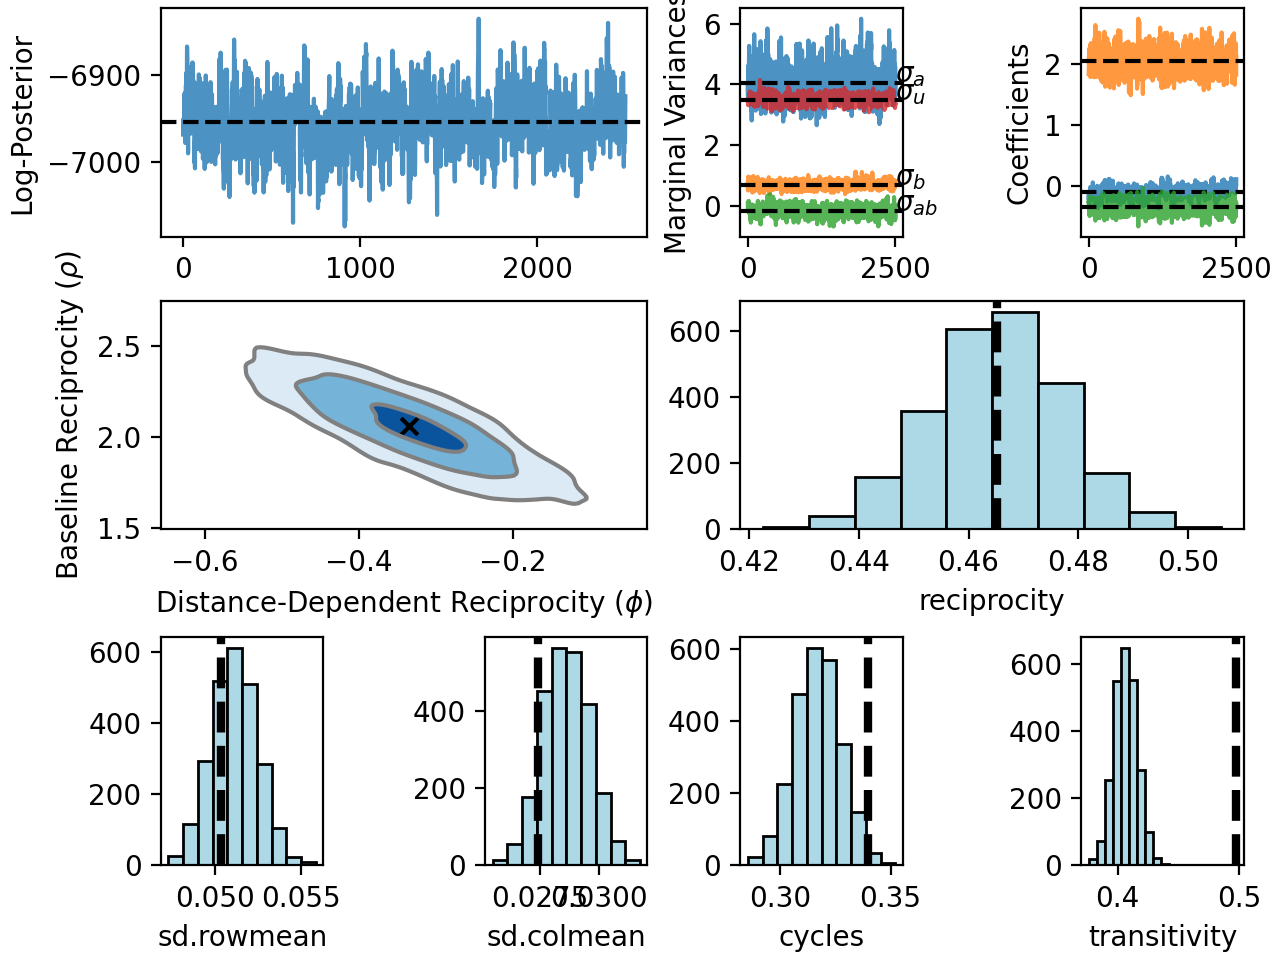

{'A': <Axes: label='A', ylabel='Log-Posterior'>,
 'B': <Axes: label='B', ylabel='Marginal Variances'>,
 'C': <Axes: label='C', ylabel='Coefficients'>,
 'D': <Axes: label='D', xlabel='Distance-Dependent Reciprocity ($\\phi$)', ylabel='Baseline Reciprocity ($\\rho$)'>,
 'E': <Axes: label='E', xlabel='reciprocity'>,
 'F': <Axes: label='F', xlabel='sd.rowmean'>,
 'G': <Axes: label='G', xlabel='sd.colmean'>,
 'H': <Axes: label='H', xlabel='cycles'>,
 'I': <Axes: label='I', xlabel='transitivity'>}

In [5]:
model.plot()

<IPython.core.display.Javascript object>


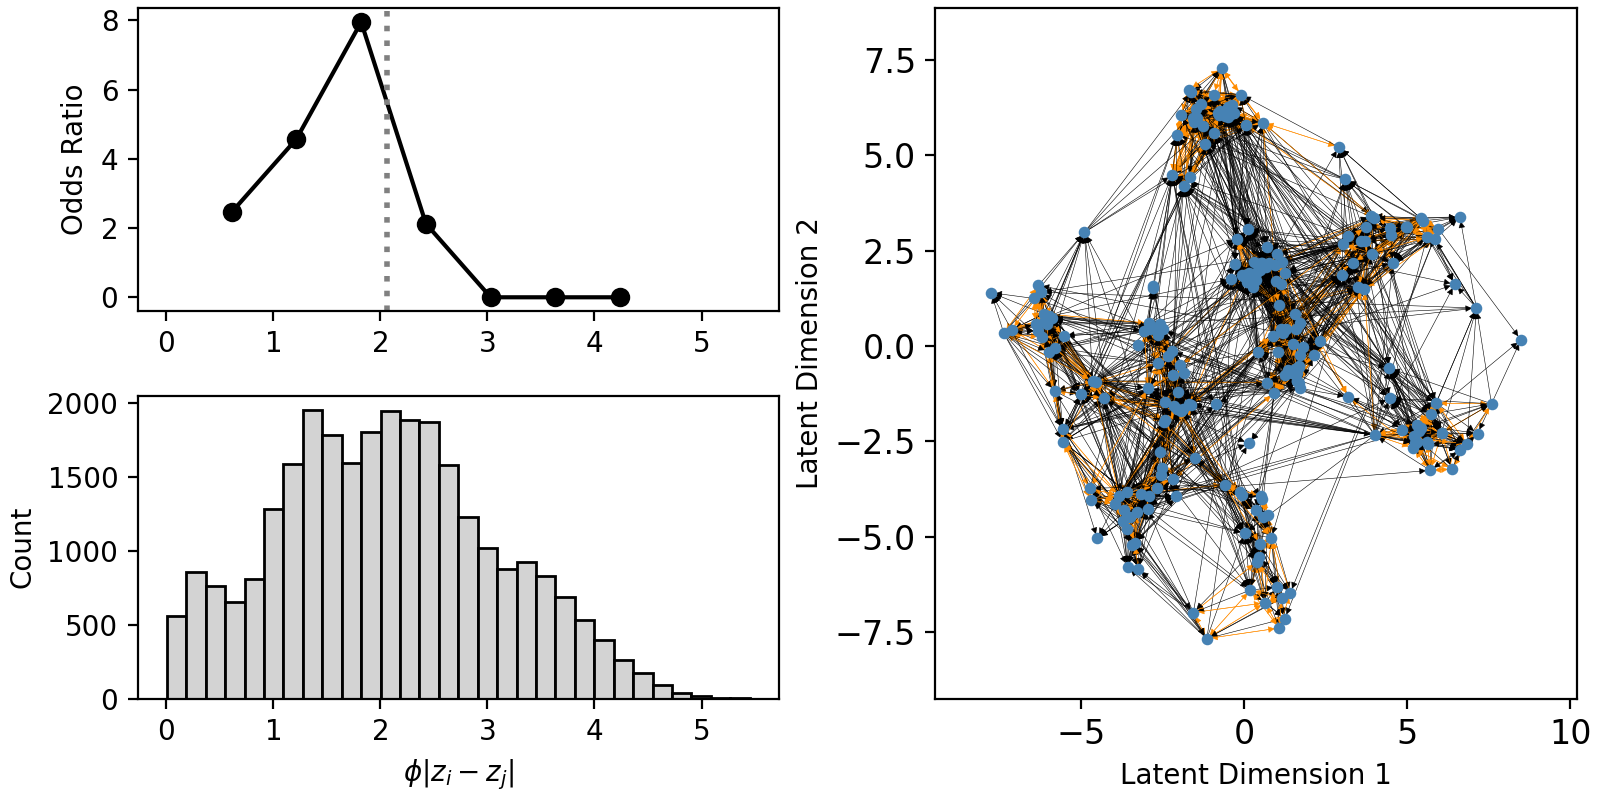

/var/folders/v3/2j2q_5r946l7qp1c47w5x7lc0000gn/T/ipykernel_82176/15069979.py:13: RuntimeWarning: invalid value encountered in sqrt
  D = np.sqrt(pairwise_distance(model.U_))


In [7]:
import networkx as nx

from rlsm.rlsm import pairwise_distance
from rlsm.network_utils import adjacency_to_dyads, dyads_to_multinomial

ax = plt.figure(constrained_layout=True, figsize=(8,4)).subplot_mosaic(
    """
    AABB
    CCBB
    """
)

D = np.sqrt(pairwise_distance(model.U_))
d = np.abs(model.samples_['dist_coef'].mean())  * adjacency_to_dyads(D, n=D.shape[0])[:, 0]
dyads = adjacency_to_dyads(Y, n=D.shape[0])

res = []
qs = np.linspace(d.min(), d.max(), 10)
dist = []
for i in range(qs.shape[0]-1):
    a = dyads_to_multinomial(dyads[np.where(np.logical_and(d >= qs[i], d <= qs[i+1]))[0]])
    tots = a.sum(axis=0) 
    gamma = (tots[0] * tots[-1]) / (tots[1] * tots[2]) 
    if tots[1] * tots[2] > 0:
        res.append(gamma)
        dist.append(qs[i+1])

ax['C'].hist(d, bins=30, color='lightgray', edgecolor='k')#.histplot(d, axes=ax[0])
ax['A'].plot(np.asarray(dist), res, 'ko-')
ax['A'].set_ylabel('Odds Ratio')
ax['A'].axvline(model.recip_coef_, linestyle=':', color='gray', lw=2)
ax['C'].set_ylabel('Count')
ax['C'].set_xlabel(r'$\phi |z_i - z_j|$')

colors = np.asarray(["tomato", "steelblue", "goldenrod"])
g = nx.from_numpy_array(Y, create_using=nx.DiGraph)
pos = {k : model.U_[k, :2] for k in range(Y.shape[0])}
elist = list(nx.to_edgelist(g))
ecolor = ['darkorange' if Y[e[1], e[0]] else 'black' for e in elist]
nx.draw_networkx(g, pos, 
                 node_color='steelblue',
                 edge_color=ecolor, width=0.2, arrowsize=5, with_labels=False,
                 node_size=10, ax=ax['B'])
ax['B'].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)
ax['B'].set_ylabel('Latent Dimension 2')
ax['B'].set_xlabel('Latent Dimension 1')
ax['A'].sharex(ax['C'])